In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('C:/Users/Administrator/Desktop/data/wine/redwhite.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt, seaborn as sns
from imblearn.over_sampling import SMOTE

from scipy.stats import pearsonr

from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from sklearn.metrics import classification_report

In [3]:


df = pd.read_csv('C:/Users/Administrator/Desktop/data/wine/redwhite.csv')
df.head()



,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [4]:
df.type.value_counts()

white    4898
red      1599
Name: type, dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6497 non-null   float64
 2   volatile acidity      6497 non-null   float64
 3   citric acid           6497 non-null   float64
 4   residual sugar        6497 non-null   float64
 5   chlorides             6497 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6497 non-null   float64
 10  sulphates             6497 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [6]:
100*df.isnull().sum()/len(df)

type                    0.0
fixed acidity           0.0
volatile acidity        0.0
citric acid             0.0
residual sugar          0.0
chlorides               0.0
free sulfur dioxide     0.0
total sulfur dioxide    0.0
density                 0.0
pH                      0.0
sulphates               0.0
alcohol                 0.0
quality                 0.0
dtype: float64

In [7]:
df = df.dropna()
100*df.isnull().sum()/len(df)

type                    0.0
fixed acidity           0.0
volatile acidity        0.0
citric acid             0.0
residual sugar          0.0
chlorides               0.0
free sulfur dioxide     0.0
total sulfur dioxide    0.0
density                 0.0
pH                      0.0
sulphates               0.0
alcohol                 0.0
quality                 0.0
dtype: float64

In [8]:
categorical_columns = list(df.select_dtypes(include='object').columns)
numerical_columns = list(df.select_dtypes(exclude='object').columns)
categorical_columns, numerical_columns

(['type'],
 ['fixed acidity',
  'volatile acidity',
  'citric acid',
  'residual sugar',
  'chlorides',
  'free sulfur dioxide',
  'total sulfur dioxide',
  'density',
  'pH',
  'sulphates',
  'alcohol',
  'quality'])

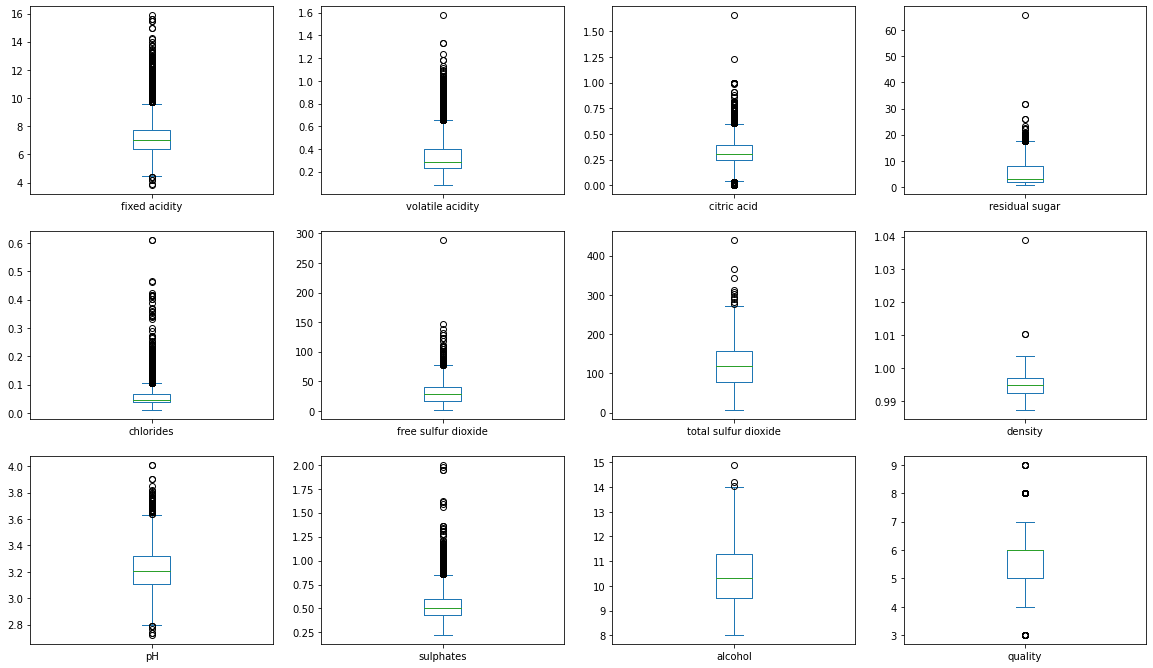

In [9]:
df[numerical_columns].plot(kind='box', subplots=True, layout=(5, 4), legend=True, figsize=(20, 20))
plt.show()


In [10]:
def outlier_removal(feature):
    Q1 = df[feature].quantile(0.25)
    Q2 = df[feature].quantile(0.75)
    IQR = Q2 - Q1
    upper = Q2 + (1.5*IQR)
    lower = Q1 - (1.5*IQR)
    new =  df[(df[feature]>=lower) & (df[feature]<=upper)]
    return new

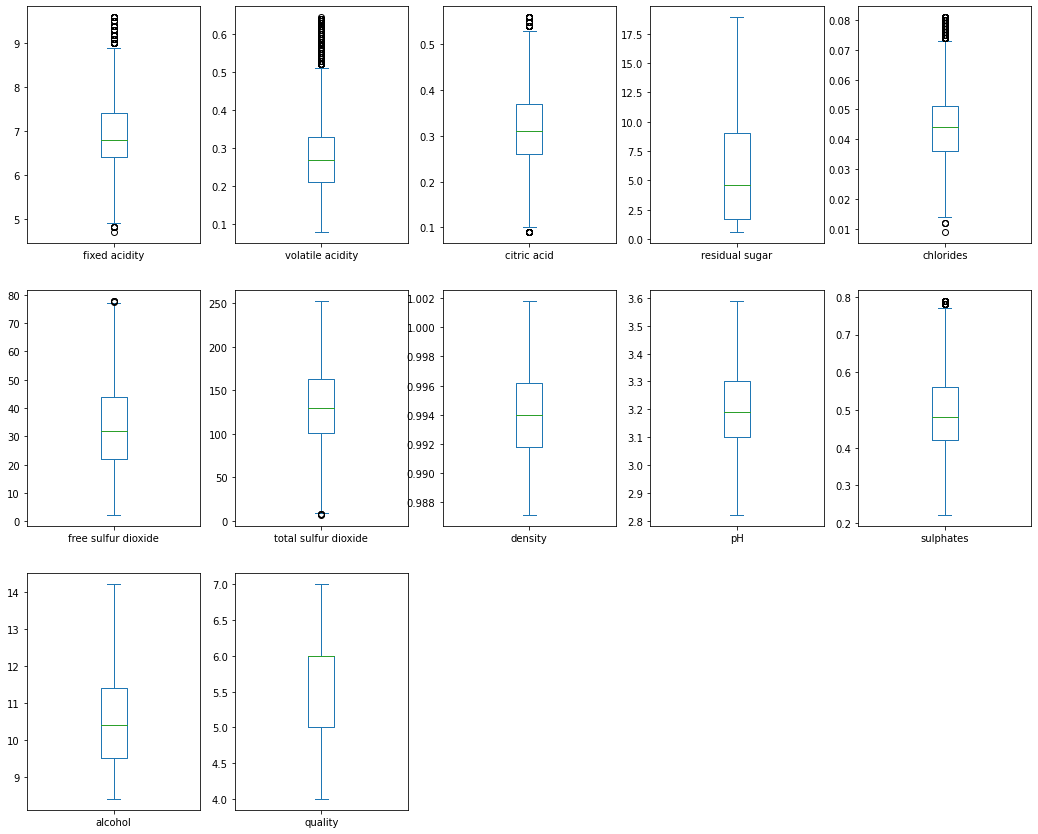

In [11]:
for columns in numerical_columns:
    df = outlier_removal(columns)
    
df[numerical_columns].plot(kind='box', subplots=True, layout=(4,5), legend=True, figsize=(18,20))
plt.show()

In [12]:


df.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 4418 entries, 1 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  4418 non-null   object 
 1   fixed acidity         4418 non-null   float64
 2   volatile acidity      4418 non-null   float64
 3   citric acid           4418 non-null   float64
 4   residual sugar        4418 non-null   float64
 5   chlorides             4418 non-null   float64
 6   free sulfur dioxide   4418 non-null   float64
 7   total sulfur dioxide  4418 non-null   float64
 8   density               4418 non-null   float64
 9   pH                    4418 non-null   float64
 10  sulphates             4418 non-null   float64
 11  alcohol               4418 non-null   float64
 12  quality               4418 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 483.2+ KB


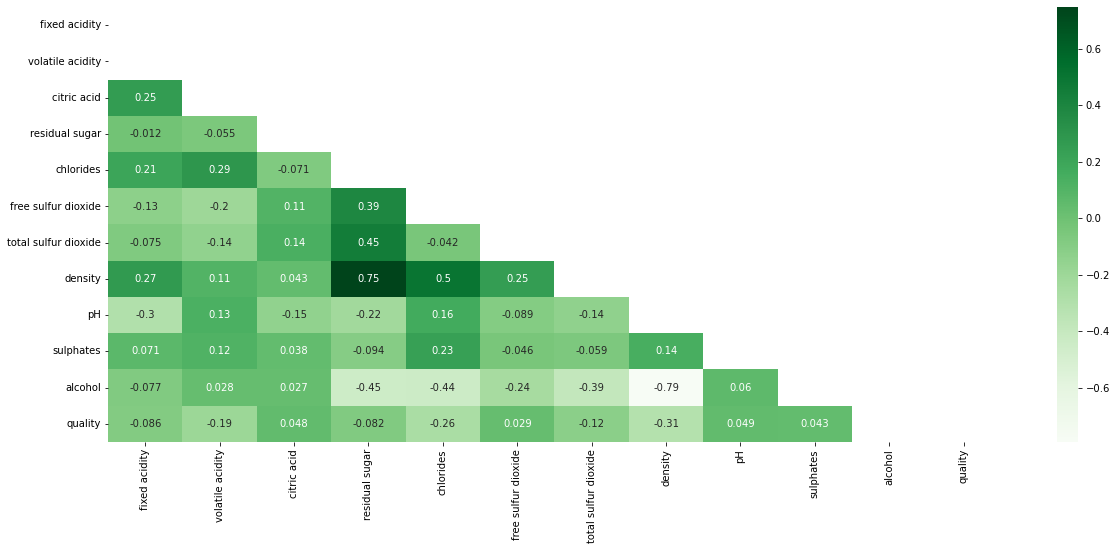

In [13]:
plt.figure(figsize=(20,8))
mask = np.triu(df.corr(),-1)
sns.heatmap(df.corr(), mask=mask, cmap='Greens', annot=True)
plt.show()

In [14]:
bian = LabelBinarizer()
y = bian.fit_transform(df.type)
new = df.copy()
new.type = y

correlation = pd.DataFrame(columns=["Relation of 'type' with", "Pearson's correlation value"])
for index, feature in enumerate(numerical_columns):
    corr,_ = pearsonr(new.type, new[feature])
    correlation.loc[index] = [feature, corr]
correlation = correlation.sort_values("Pearson's correnation value", ascending=False)
    
correlation

,Relation of 'type' with,Pearson's correnation value
6,total sulfur dioxide,0.496376
5,free sulfur dioxide,0.296179
3,residual sugar,0.221220
2,citric acid,0.134358
11,quality,0.059016
10,alcohol,0.009163
7,density,-0.191247
0,fixed acidity,-0.244720
8,pH,-0.293070
9,sulphates,-0.327025


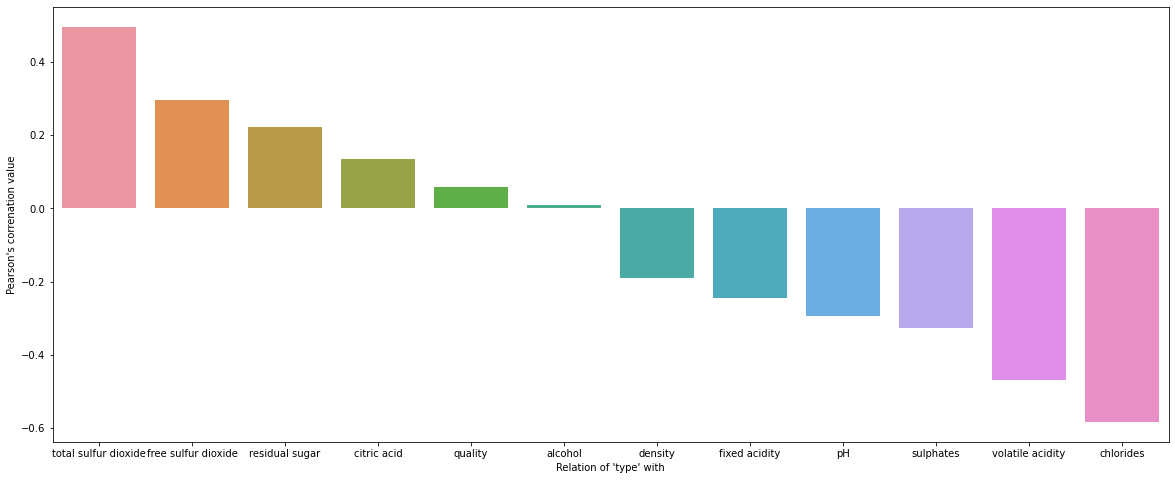

In [15]:
plt.figure(figsize=(20,8))
sns.barplot(x=correlation["Relation of 'type' with"], y=correlation["Pearson's correnation value"])
plt.show()

In [16]:
train, test = train_test_split(df, train_size=0.7, random_state=100, stratify=df.type)

In [17]:
X_train = train[numerical_columns]
y_train = train.type

X_test = test[numerical_columns]
y_test = test.type

In [18]:
y_train.value_counts()

white    2846
red       246
Name: type, dtype: int64

In [19]:
smote = SMOTE()
x_smote, y_smote = smote.fit_resample(X_train, y_train)

y_smote.value_counts()

white    2846
red      2846
Name: type, dtype: int64

In [20]:
scaler = MinMaxScaler()
x_smote[numerical_columns] = scaler.fit_transform(x_smote[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

C:\Users\ADMINI~1\AppData\Local\Temp\1/ipykernel_5632/2228261010.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])


In [21]:
lr = LogisticRegression(random_state=22)
folds = KFold(n_splits=5, shuffle=True, random_state=45)
score = cross_val_score(estimator=lr, X=x_smote, y=y_smote, scoring='accuracy', cv=folds, n_jobs=-1)
score.mean()

0.9871747948976302

In [22]:
lr.fit(x_smote, y_smote)
test['predicted_type'] = lr.predict(X_test)

In [23]:
print(classification_report(y_test, test.predicted_type))

              precision    recall  f1-score   support

         red       0.97      0.97      0.97       106
       white       1.00      1.00      1.00      1220

    accuracy                           1.00      1326
   macro avg       0.98      0.98      0.98      1326
weighted avg       1.00      1.00      1.00      1326



In [24]:
from sklearn.metrics import confusion_matrix, classification_report
#Confusion matrix for the LogisticRegression classification
print(confusion_matrix(y_test, test.predicted_type))

[[ 103    3]
 [   3 1217]]


In [25]:
cm = confusion_matrix(y_test, test.predicted_type)
cm

array([[ 103,    3],
       [   3, 1217]], dtype=int64)

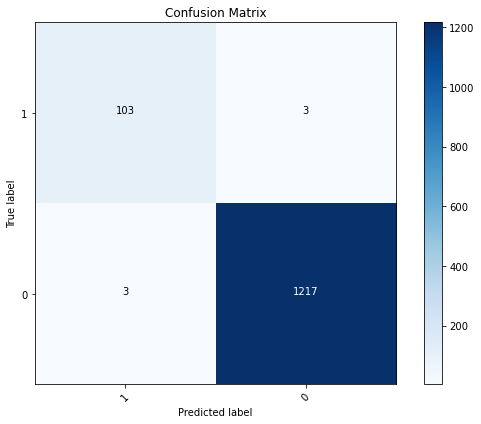

In [26]:
import numpy as np

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
class_labels=["1" , "0"]
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [27]:
# Random Forest

In [28]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=22, max_features= 4, max_depth= 12)
folds = KFold(n_splits=5, shuffle=True, random_state=45)
score = cross_val_score(estimator=rf, X=x_smote, y=y_smote, scoring='accuracy', cv=folds, n_jobs=-1)
score.mean()

0.9943785672073829

In [29]:
rf.fit(x_smote, y_smote)
test['predicted_type'] = rf.predict(X_test)

In [30]:
print(classification_report(y_test, test.predicted_type))

              precision    recall  f1-score   support

         red       1.00      0.96      0.98       106
       white       1.00      1.00      1.00      1220

    accuracy                           1.00      1326
   macro avg       1.00      0.98      0.99      1326
weighted avg       1.00      1.00      1.00      1326



In [31]:
from sklearn.metrics import confusion_matrix, classification_report
#Confusion matrix for the Random forest classification
print(confusion_matrix(y_test, test.predicted_type))

[[ 102    4]
 [   0 1220]]


In [32]:
cm = confusion_matrix(y_test, test.predicted_type)
cm

array([[ 102,    4],
       [   0, 1220]], dtype=int64)

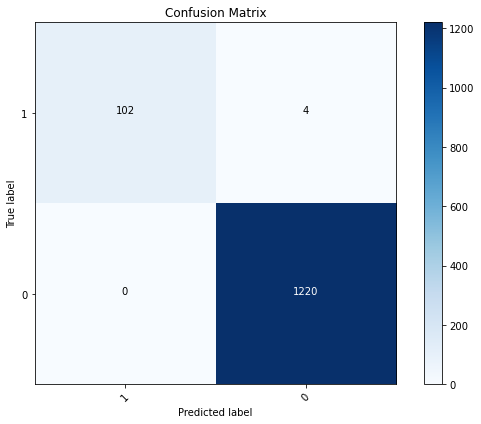

In [33]:
import numpy as np

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
class_labels=["1" , "0"]
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [34]:
from sklearn.svm import SVC
svm=SVC()
folds = KFold(n_splits=5, shuffle=True, random_state=45)
score = cross_val_score(estimator=svm, X=x_smote, y=y_smote, scoring='accuracy', cv=folds, n_jobs=-1)
score.mean()

0.9949047278854358

In [35]:
#svm
svm.fit(x_smote, y_smote)
test['predicted_type'] = svm.predict(X_test)

In [36]:
print(classification_report(y_test, test.predicted_type))

              precision    recall  f1-score   support

         red       0.97      0.96      0.97       106
       white       1.00      1.00      1.00      1220

    accuracy                           0.99      1326
   macro avg       0.98      0.98      0.98      1326
weighted avg       0.99      0.99      0.99      1326



In [37]:
from sklearn.metrics import confusion_matrix, classification_report
#Confusion matrix for the SVM classification
print(confusion_matrix(y_test, test.predicted_type))

[[ 102    4]
 [   3 1217]]


In [38]:
cm = confusion_matrix(y_test, test.predicted_type)
cm

array([[ 102,    4],
       [   3, 1217]], dtype=int64)

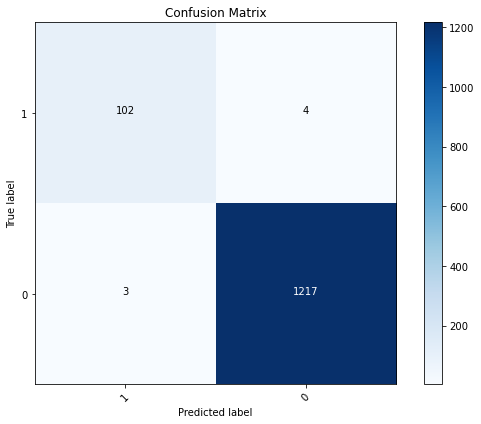

In [39]:
import numpy as np

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
class_labels=["1" , "0"]
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [40]:
# knn
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors=5)
folds = KFold(n_splits=5, shuffle=True, random_state=45)
score = cross_val_score(estimator=knn, X=x_smote, y=y_smote, scoring='accuracy', cv=folds, n_jobs=-1)
score.mean()


0.9942018944870397

In [41]:
knn.fit(x_smote, y_smote)
test['predicted_type'] = knn.predict(X_test)


In [42]:
print(classification_report(y_test, test.predicted_type))

              precision    recall  f1-score   support

         red       0.94      0.97      0.96       106
       white       1.00      1.00      1.00      1220

    accuracy                           0.99      1326
   macro avg       0.97      0.98      0.98      1326
weighted avg       0.99      0.99      0.99      1326



In [43]:
cm = confusion_matrix(y_test, test.predicted_type)
cm

array([[ 103,    3],
       [   6, 1214]], dtype=int64)

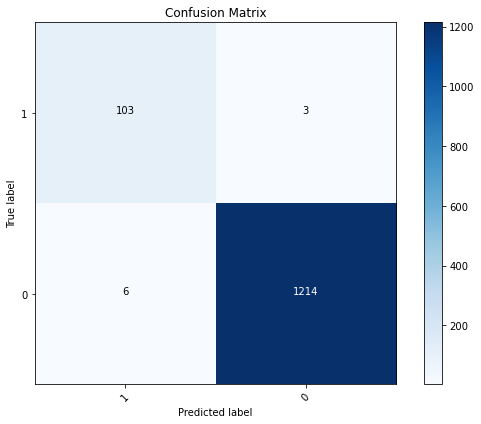

In [44]:
import numpy as np

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
class_labels=["1" , "0"]
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [45]:
# decision tree
from sklearn.tree import DecisionTreeClassifier
dt=DecisionTreeClassifier()
folds = KFold(n_splits=5, shuffle=True, random_state=45)
score = cross_val_score(estimator=dt, X=x_smote, y=y_smote, scoring='accuracy', cv=folds, n_jobs=-1)
score.mean()

0.989809918668829

In [46]:
dt.fit(x_smote, y_smote)
test['predicted_type'] = dt.predict(X_test)

In [47]:
print(classification_report(y_test, test.predicted_type))

              precision    recall  f1-score   support

         red       0.90      0.93      0.92       106
       white       0.99      0.99      0.99      1220

    accuracy                           0.99      1326
   macro avg       0.95      0.96      0.95      1326
weighted avg       0.99      0.99      0.99      1326



In [48]:
cm = confusion_matrix(y_test, test.predicted_type)
cm

array([[  99,    7],
       [  11, 1209]], dtype=int64)

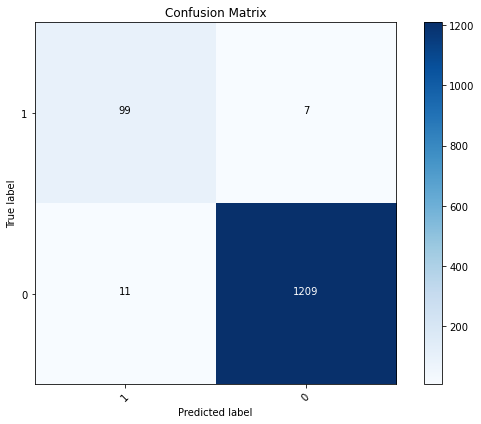

In [49]:
import numpy as np

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
class_labels=["1" , "0"]
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [50]:

# naive bayes
from sklearn.naive_bayes import GaussianNB
nb=GaussianNB()
folds = KFold(n_splits=5, shuffle=True, random_state=45)
score = cross_val_score(estimator=nb, X=x_smote, y=y_smote, scoring='accuracy', cv=folds, n_jobs=-1)
score.mean()

0.9824325596251142

In [51]:
nb.fit(x_smote, y_smote)
test['predicted_type'] = nb.predict(X_test)

In [52]:
print(classification_report(y_test, test.predicted_type))

              precision    recall  f1-score   support

         red       0.96      0.96      0.96       106
       white       1.00      1.00      1.00      1220

    accuracy                           0.99      1326
   macro avg       0.98      0.98      0.98      1326
weighted avg       0.99      0.99      0.99      1326



In [53]:
cm = confusion_matrix(y_test, test.predicted_type)
cm

array([[ 102,    4],
       [   4, 1216]], dtype=int64)

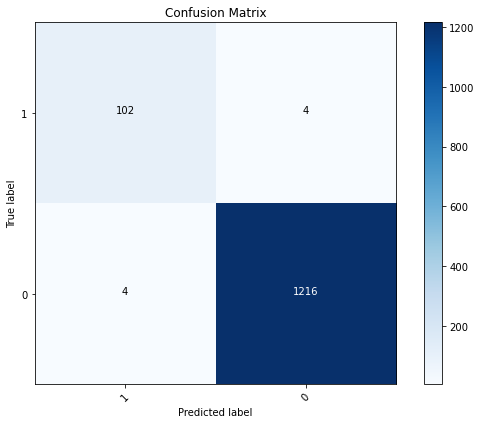

In [54]:
import numpy as np

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
class_labels=["1" , "0"]
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [55]:
# Development of the benchmark Model for comparisonm
#The mopdel is subjected to the same Data 
from sklearn.neural_network import MLPClassifier
# Neural Network
# Create Model with configuration 
nn_model = MLPClassifier(solver='adam', 
                         alpha=1e-5,
                         hidden_layer_sizes=(50,), 
                         random_state=1,
                         max_iter=1500                         
                        )

# Model Training
nn_model.fit(x_smote, y_smote)
             

# Prediction
#result = nn_model.predict(y[Features]) 

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(50,), max_iter=1500,
              random_state=1)

In [56]:
y_pred = nn_model.predict(X_test)



In [57]:
from sklearn.metrics import accuracy_score
# Calculate the accuracy of the model
score = accuracy_score(y_test, test.predicted_type)

In [58]:
# Print the accuracy of the model
print(f"Accuracy: {score}")

Accuracy: 0.9939668174962293


In [59]:
test['predicted_type'] =nn_model.predict(X_test)

In [60]:
print(classification_report(y_test, test.predicted_type))

              precision    recall  f1-score   support

         red       0.96      0.97      0.97       106
       white       1.00      1.00      1.00      1220

    accuracy                           0.99      1326
   macro avg       0.98      0.98      0.98      1326
weighted avg       0.99      0.99      0.99      1326



In [61]:
cm = confusion_matrix(y_test, test.predicted_type)
cm

array([[ 103,    3],
       [   4, 1216]], dtype=int64)

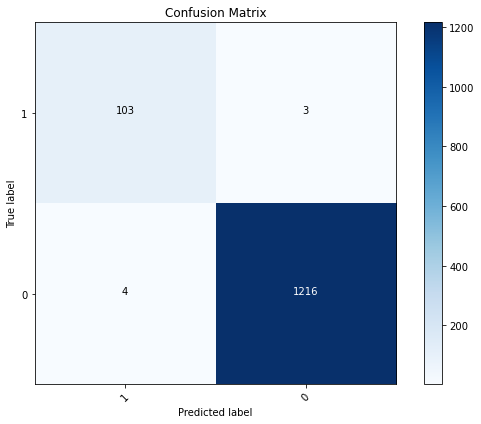

In [62]:
import numpy as np

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
class_labels=["1" , "0"]
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [63]:
models = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Support Vector Machine','KNN', 'Decision Tree','Naive Bayes', 
               'Neural Network' ],
    'Score': [lr,rf,svm,knn,dt,nb,nn_model]})

In [64]:
import pandas as pd

# Convert 'Score' column to numeric
models['Score'] = pd.to_numeric(models['Score'], errors='coerce')

# Sort models by score in descending order
models.sort_values(by='Score', ascending=False, inplace=True)

print(models)


                    Model  Score
0       Linear Regression    NaN
1           Random Forest    NaN
2  Support Vector Machine    NaN
3                     KNN    NaN
4           Decision Tree    NaN
5             Naive Bayes    NaN
6          Neural Network    NaN


In [65]:


# show all the models 
models.sort_values(by='Score', ascending=False)



,Model,Score
0,Linear Regression,NaN
1,Random Forest,NaN
2,Support Vector Machine,NaN
3,KNN,NaN
4,Decision Tree,NaN
5,Naive Bayes,NaN
6,Neural Network,NaN


In [66]:
import pandas as pd

models = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Support Vector Machine', 'KNN', 'Decision Tree', 'Naive Bayes', 'Neural Network'],
    'Score': [accuracy_score(y_test, lr.predict(X_test)), accuracy_score(y_test, rf.predict(X_test)), accuracy_score(y_test, svm.predict(X_test)), accuracy_score(y_test, knn.predict(X_test)), accuracy_score(y_test, dt.predict(X_test)), accuracy_score(y_test, nb.predict(X_test)), accuracy_score(y_test, nn_model.predict(X_test))]
})

models.sort_values(by='Score', ascending=False, inplace=True)


In [67]:
# show all the models 
models.sort_values(by='Score', ascending=True)

,Model,Score
4,Decision Tree,0.986425
3,KNN,0.993213
5,Naive Bayes,0.993967
2,Support Vector Machine,0.994721
6,Neural Network,0.994721
0,Linear Regression,0.995475
1,Random Forest,0.996983


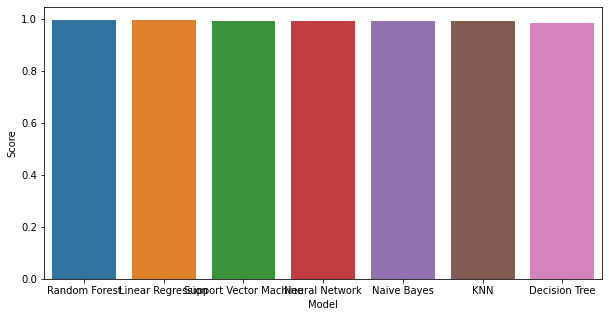

In [68]:
#plotting the graph 
plt.figure(figsize=(10,5))
sns.barplot(x='Model',y='Score',data=models)
plt.show()